In [1]:
!pip install pillow



In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pdf2image

Note: you may need to restart the kernel to use updated packages.


In [4]:
from pdf2image import convert_from_path
import os

# Convert PDF pages to images
pdf_path = '/home/vamsi.srivathsa/pritam.k/sriman/Padilla - Nobleza virtuosa_testExtract.pdf'
images = convert_from_path(pdf_path, dpi=300)  # Use high DPI for better resolution

# Save images
image_folder = 'pdf2images'
os.makedirs(image_folder, exist_ok=True)

image_paths = []
for i, image in enumerate(images):
    image_path = os.path.join(image_folder, f'page_{i}.jpg')
    image.save(image_path, 'JPEG')
    image_paths.append(image_path)

print(f"Converted {len(images)} pages to images.")


Converted 16 pages to images.


In [5]:
from PIL import Image, ImageFilter
import cv2
import numpy as np

def preprocess_image(image_path):
    # Open the image
    image = Image.open(image_path)
    
    # Convert image to grayscale
    image = image.convert('L')
    
    # Apply a median filter for noise reduction
    image = image.filter(ImageFilter.MedianFilter(size=3))
    
    # Convert to NumPy array for OpenCV processing
    image_np = np.array(image)
    
    # Binarization using Otsu's thresholding
    _, binarized_image = cv2.threshold(image_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Convert back to PIL Image and save or return for further processing
    processed_image_path = image_path.replace('/images/', '/processed_images/')
    os.makedirs(os.path.dirname(processed_image_path), exist_ok=True)
    Image.fromarray(binarized_image).save(processed_image_path)
    return processed_image_path

# Preprocess all images
processed_image_paths = [preprocess_image(path) for path in image_paths]


In [6]:
def split_columns(image_path):
    image = Image.open(image_path)
    width, height = image.size
    
    # Assuming two columns of equal width
    split_point = width // 2
    
    # Crop the left and right parts of the image
    left_column = image.crop((0, 0, split_point, height))
    right_column = image.crop((split_point, 0, width, height))
    
    # Save the columns
    left_path = image_path.replace('.jpg', '_left.jpg')
    right_path = image_path.replace('.jpg', '_right.jpg')
    left_column.save(left_path)
    right_column.save(right_path)
    
    return left_path, right_path

# Split all processed images into columns
columns_paths = [split_columns(path) for path in processed_image_paths]


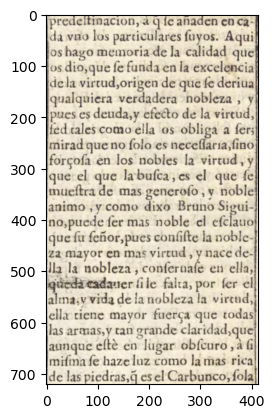

In [13]:
import matplotlib.pyplot as plt
import cv2

# img=cv2.imread('/home/vamsi.srivathsa/pritam.k/sriman/pdf2images/page_1_left.jpg')
img=cv2.imread('/home/vamsi.srivathsa/pritam.k/sriman/pdf2images/2.png')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h,w,c=img.shape

if w>1000 :
    new_w=1000
    ar=w/h
    new_h=int(new_w/ar)
    img = cv2.resize(img, (new_w, new_h), interpolation = cv2.INTER_AREA)

plt.imshow(img) 


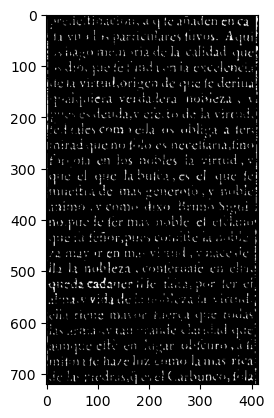

In [36]:
def thresholding(image):
    img_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,thresh = cv2.threshold(img_gray,90,255,cv2.THRESH_BINARY_INV)
    plt.imshow(thresh, cmap='gray')
    return thresh

thresh_img = thresholding(img);

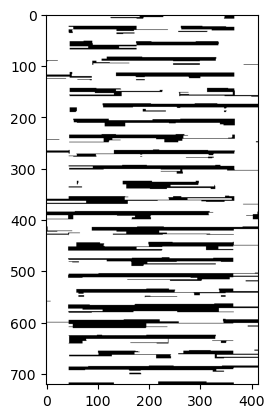

In [37]:
#dilation
kernel = np.ones((3,85), np.uint8)
dilated = cv2.dilate(thresh_img, kernel, iterations = 1)
plt.imshow(dilated, cmap='gray');

In [38]:
(contours, heirarchy) = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
sorted_contours_lines = sorted(contours, key = lambda ctr : cv2.boundingRect(ctr)[1]) # (x, y, w, h)

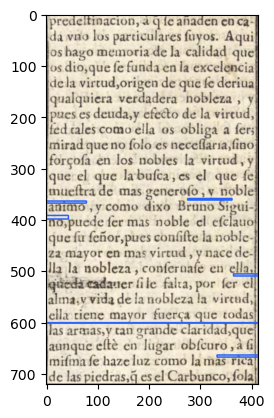

In [39]:
img2 = img.copy()

for ctr in sorted_contours_lines:
    
    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w, y+h), (40, 100, 250), 2)
    
plt.imshow(img2)

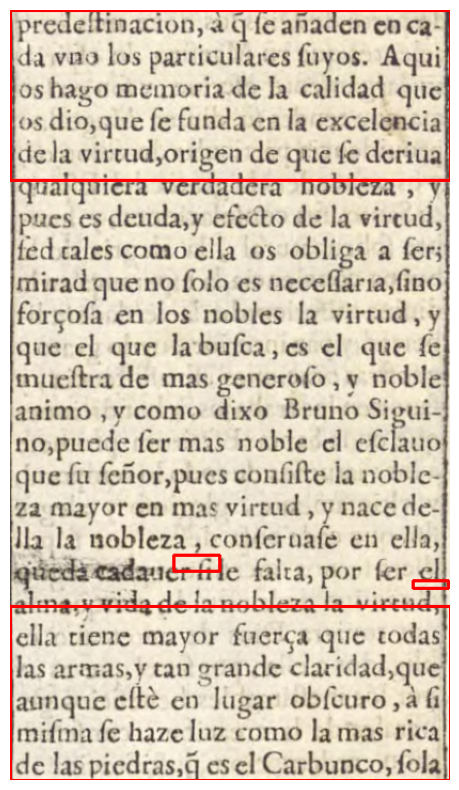

In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation as inter

# Function to load the image
def load_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Function to resize the image if it's too large
def resize_image(image, max_width=1000):
    h, w, c = image.shape
    if w > max_width:
        new_w = max_width
        ar = w / h
        new_h = int(new_w / ar)
        image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return image

# Function for adaptive thresholding
def adaptive_thresholding(image):
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    thresh = cv2.adaptiveThreshold(
        img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    return thresh

# Function to deskew the image
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

# Function to find contours and draw bounding boxes on the original image
def find_and_draw_contours(thresh_img, original_img):
    contours, hierarchy = cv2.findContours(thresh_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours_lines = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])

    img_with_rects = original_img.copy()
    for ctr in sorted_contours_lines:
        x, y, w, h = cv2.boundingRect(ctr)
        if w > 30 and h >2:  # Filter to eliminate too small rectangles
            cv2.rectangle(img_with_rects, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    return img_with_rects

# Path to the uploaded image
img_path = '/home/vamsi.srivathsa/pritam.k/sriman/pdf2images/2.png'

# Load and preprocess the image
img = load_image(img_path)
img = resize_image(img)

# Apply adaptive thresholding
thresh_img = adaptive_thresholding(img)

# Deskew the image
deskewed_img = deskew(thresh_img)

# Find and draw contours
img_with_lines = find_and_draw_contours(deskewed_img, img)

# Show the final image with bounding boxes
plt.figure(figsize=(10,10))
plt.imshow(img_with_lines)
plt.axis('off')
plt.show()

